In [1]:
%load_ext autoreload

In [23]:
%autoreload now

In [3]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random


In [4]:
from utils.dataset_utils import load_images, load_domain_dataset
from utils.vis_utils import view_random_image

## Visualizing our data

In [5]:
# walking through the iphone2dslr_flower dataset
# Checking how amany files we have 

for dirpath, dirnames, filenames in os.walk("iphone2dslr_flower"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 4 directories and 0 images in 'iphone2dslr_flower
There are 0 directories and 569 images in 'iphone2dslr_flower\testA
There are 0 directories and 480 images in 'iphone2dslr_flower\testB
There are 0 directories and 1812 images in 'iphone2dslr_flower\trainA
There are 0 directories and 3325 images in 'iphone2dslr_flower\trainB


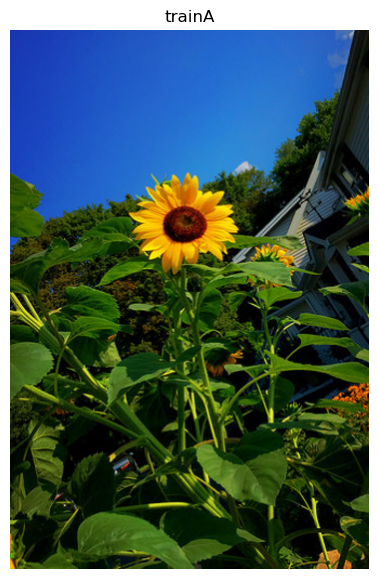

In [6]:
view_random_image("iphone2dslr_flower/", "trainA")

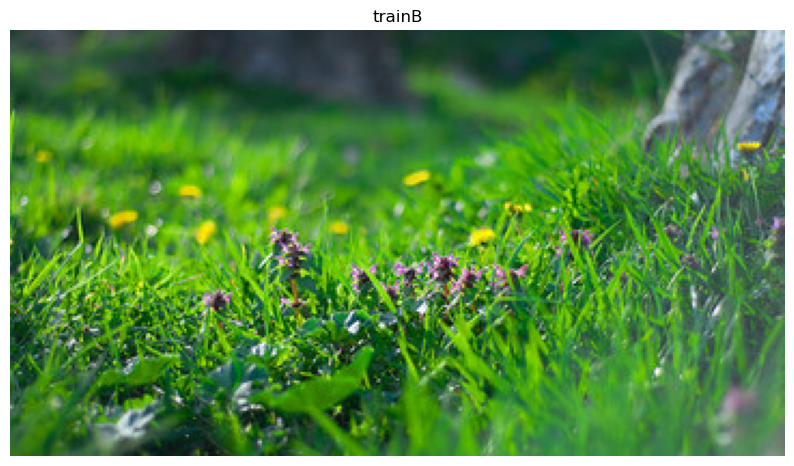

In [7]:
view_random_image("iphone2dslr_flower/", "trainB")

## Importing Dataset

###  Setting Up mixed Precision

In [9]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

### Dataset

In [10]:
# base_path = os.path.join(os.getcwd(), "iphone2dslr_flower/")

# trainA = load_images(base_path + "trainA/", 256)
# trainB = load_images(base_path + "trainB/", 256)

In [10]:
data_dir = os.path.join(os.getcwd(), "iphone2dslr_flower/")

trainA = load_domain_dataset(os.path.join(data_dir, "trainA/"))
trainB = load_domain_dataset(os.path.join(data_dir, "trainB/"))

Found 1812 files belonging to 1 classes.
Found 3325 files belonging to 1 classes.


In [11]:
dataset = tf.data.Dataset.zip((trainA, trainB))

In [12]:
dataset.shuffle(buffer_size=len(dataset)- 1).cache().prefetch(tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>

In [13]:
dataset = dataset.map(lambda x, y: (x/255.0, y/255.0))

## Creating CycleGAN Model

- Generator_G -> A-> B
- Generator_F -> B -> A
- Discriminator_G  -> how fake is $B_{syn}$ generated from A, with respect to B
- Discriminator_F -> how close is $A_{syn}$ generated from B

In [201]:
from models.losses import AdverserialLoss

In [259]:
tf.random.set_seed(42)

class CycleGAN(tf.keras.Model):

    def __init__(self,
                 gen_G,
                 gen_F,
                 discriminator_X,
                 discriminator_Y,
                 lambda_cycle = 10,
                 identity_weight = 0.5):
        super().__init__()
        self.gen_G = gen_G
        self.gen_F = gen_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.ident_weight = identity_weight
    
    def compile(self,
                optimizer_gen_G,
                optimizer_gen_F,
                optimizer_disc_X,
                optimizer_disc_Y,
                ):
        super().compile()
        self.optimizer_gen_G = optimizer_gen_G
        self.optimizer_gen_F = optimizer_gen_F
        self.optimizer_disc_X = optimizer_disc_X
        self.optimizer_disc_Y = optimizer_disc_Y
        self.gen_loss_fn = AdverserialLoss.generator_loss
        self.disc_loss_fn = AdverserialLoss.discriminator_loss
        self.identity_loss = tf.keras.losses.MeanAbsoluteError()
        self.cycle_loss = tf.keras.losses.MeanAbsoluteError()

    def train_step(self, data):

        real_A_img, real_B_img = data

        with tf.GradientTape(persistent=True) as tape:

            # Adverserial Losses
            gen_B_img = self.gen_G(real_A_img, training = True)
            gen_A_img = self.gen_F(real_B_img, training=True)

            # Cycle Consistency
            cycled_A_img = self.gen_F(gen_B_img, training = True)            
            cycled_B_img = self.gen_G(gen_A_img, training = True)

            cycled_loss_F = self.cycle_loss(real_A_img, cycled_A_img) * self.lambda_cycle
            cycled_loss_G = self.cycle_loss(real_B_img, cycled_B_img) * self.lambda_cycle

            # Identity
            ident_img_A = self.gen_F(real_A_img, training=True)
            id_loss_gen_F = self.identity_loss(real_A_img, ident_img_A) * self.lambda_cycle * self.ident_weight

            ident_img_B = self.gen_G(real_B_img, training=True) 
            id_loss_gen_G = self.identity_loss(real_B_img, ident_img_B) * self.lambda_cycle * self.ident_weight


            # Discriminator Losses
            # discriminator outputs
            disc_img_B = self.disc_Y(real_B_img)
            disc_img_gen_B = self.disc_Y(gen_B_img)
            disc_Y_loss = self.disc_loss_fn(disc_img_B, disc_img_gen_B)

            disc_img_A = self.disc_X(real_A_img)
            disc_img_gen_A = self.disc_X(gen_A_img)
            disc_X_loss = self.disc_loss_fn(disc_img_A, disc_img_gen_A)

            gen_G_adv_loss = self.gen_loss_fn(disc_img_gen_B)
            gen_F_adv_loss = self.gen_loss_fn(disc_img_gen_A)

            total_loss_gen_G = gen_G_adv_loss + cycled_loss_G + id_loss_gen_G
            total_loss_gen_F = gen_F_adv_loss + cycled_loss_F + id_loss_gen_F


        grad_gen_G = tape.gradient(total_loss_gen_G, self.gen_G.trainable_variables)
        grad_gen_F = tape.gradient(total_loss_gen_F, self.gen_F.trainable_variables)

        grad_disc_X = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        grad_disc_Y = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        self.optimizer_gen_G.apply_gradients(zip(grad_gen_G, self.gen_G.trainable_variables))

        self.optimizer_gen_F.apply_gradients(zip(grad_gen_F, self.gen_F.trainable_variables))
        
        self.optimizer_disc_X.apply_gradients(zip(grad_disc_X, self.disc_X.trainable_variables))
        self.optimizer_disc_Y.apply_gradients(zip(grad_disc_Y, self.disc_Y.trainable_variables))

        return {
            "gen_G_loss": total_loss_gen_G,
            "gen_F_loss": total_loss_gen_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss
        }

In [260]:
from models.model import create_generator, create_discriminator

In [261]:
gen_G = create_generator("generator_G", 9)
gen_F = create_generator("generator_F", 9)

disc_X = create_discriminator((256, 256, 3))
disc_Y = create_discriminator((256, 256, 3))

In [262]:
cycle_gan_model = CycleGAN(
    gen_G,
    gen_F,
    disc_X,
    disc_Y,
    10,
    0.5
)

### Creating callbacks

In [263]:
def cycle_gan_rate_scheduler_func(epoch, learning_rate):
    lr_decay_factor = (0 - 2e-4)/100
    if epoch > 99:
        learning_rate = learning_rate - lr_decay_factor
    return learning_rate

lr_callback = tf.keras.callbacks.LearningRateScheduler(cycle_gan_rate_scheduler_func)

In [264]:
class GANSaveProg(tf.keras.callbacks.Callback):
    """
    Save progress after every 5 epochs
    The callback will accept upto 2 image file locations. 

    It will make predictions and save the plot in desired file location.
    """
    def __init__(self, save_path):
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:
            fig, ax = plt.subplots(1, 2, figsize=(10, 7))
            for img in trainA.take(1):
                img = img.numpy()/255.0
                prediction = self.model.gen_G(tf.expand_dims(img, axis=0))[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                ax[0].imshow(img)
                ax[0].set_title("domain A image")
                ax[0].axis("off")
                ax[1].imshow(prediction)
                ax[1].set_title("Translated image")
                ax[1].axis("off")
                fig.savefig(f"{self.save_path}/generated_img_epoch_{epoch}.png")
                plt.close()


In [265]:
checkpoint_fp = "/tmp/checkpoint/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_fp, 
    save_weights_only=True, 
)

### Compiling and fitting the model

In [266]:
lr = 2e-4
b1 = 0.5 
gen_G_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1)
gen_F_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1)
disc_X_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1)
disc_y_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1)

In [267]:
cycle_gan_model.compile(
    optimizer_gen_G = gen_G_optimizer,
    optimizer_gen_F = gen_F_optimizer, 
    optimizer_disc_X = disc_X_optimizer,
    optimizer_disc_Y = disc_y_optimizer
)

In [268]:
save_prog_path = os.path.join(os.getcwd(), "progress/")
save_prog_callback = GANSaveProg(save_prog_path)

In [269]:
history_cycle_gan = cycle_gan_model.fit(
    dataset.batch(1), 
    epochs=20,
    callbacks=[save_prog_callback, lr_callback, checkpoint_callback]
)

Epoch 1/20
1812/1812 [==============================] - 622s 320ms/step - gen_G_loss: 0.3376 - gen_F_loss: 0.3491 - D_X_loss: 0.2968 - D_Y_loss: 0.2926 - lr: 0.0010
Epoch 2/20
1812/1812 [==============================] - 581s 320ms/step - gen_G_loss: 0.3329 - gen_F_loss: 0.3519 - D_X_loss: 0.2514 - D_Y_loss: 0.2584 - lr: 0.0010
Epoch 3/20
1812/1812 [==============================] - 580s 319ms/step - gen_G_loss: 0.3031 - gen_F_loss: 0.3793 - D_X_loss: 0.2337 - D_Y_loss: 0.2612 - lr: 0.0010
Epoch 4/20
1812/1812 [==============================] - 572s 315ms/step - gen_G_loss: 0.3362 - gen_F_loss: 0.3945 - D_X_loss: 0.2221 - D_Y_loss: 0.2491 - lr: 0.0010
Epoch 5/20
1812/1812 [==============================] - 586s 323ms/step - gen_G_loss: 0.3151 - gen_F_loss: 0.3902 - D_X_loss: 0.2118 - D_Y_loss: 0.2513 - lr: 0.0010
Epoch 6/20
1812/1812 [==============================] - 573s 315ms/step - gen_G_loss: 0.2995 - gen_F_loss: 0.3824 - D_X_loss: 0.2130 - D_Y_loss: 0.2552 - lr: 0.0010
Epoch 7/20

In [ ]:
gen_F.summary()

Model: "generator_F"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reflection_pad2d_63 (Reflectio  (None, 262, 262, 3)  0          ['input_7[0][0]']                
 nPad2D)                                                                                          
                                                                                                  
 conv2d_81 (Conv2D)             (None, 256, 256, 64  9408        ['reflection_pad2d_63[0][0]']    
                                )                                                       

In [219]:
for img in trainA.take(1):
    img = img.numpy()/255.0
    print(img.shape)

(256, 256, 3)


In [220]:
pred = gen_G(tf.expand_dims(img, axis=0))[0].numpy()

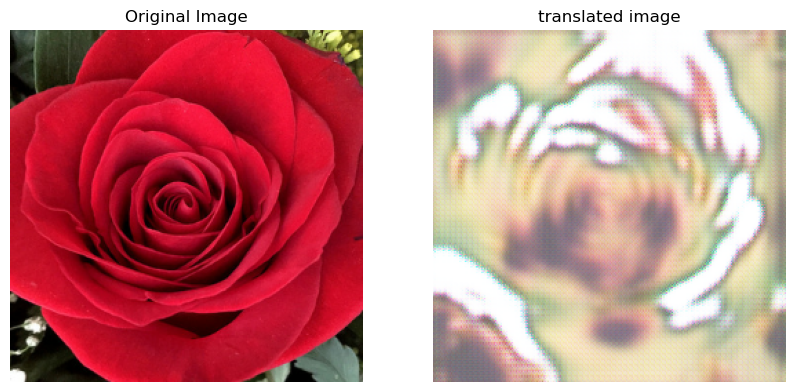

In [256]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(img)
ax[0].axis(False)
ax[0].set_title("Original Image")
prediction = (pred * 127.5 + 127.5).astype(np.uint8)
ax[1].imshow(prediction)
ax[1].set_title("translated image")
ax[1].axis(False)
plt.show()

In [140]:
ax[0] == ax[1]

False

In [258]:
for _ in trainA.take(1):
    print(_.numpy())

[[[115.01306  143.01306   95.01306 ]
  [114.359375 142.35938   94.359375]
  [113.14844  141.13281   93.17969 ]
  ...
  [ 34.164062  38.804688  31.804688]
  [ 35.890747  41.351685  31.750366]
  [ 37.796875  43.257812  33.4375  ]]

 [[116.64856  144.64856   96.64856 ]
  [117.078125 145.07812   97.078125]
  [115.03845  143.02283   95.0697  ]
  ...
  [ 34.453735  37.445312  30.462158]
  [ 35.10193   38.10193   30.741821]
  [ 36.179688  39.179688  31.257812]]

 [[117.203125 145.20312   97.203125]
  [118.       146.        98.      ]
  [115.953125 143.9375    95.984375]
  ...
  [ 34.912476  36.114014  30.914062]
  [ 34.547485  35.75061   30.196533]
  [ 33.36499   34.568115  28.466553]]

 ...

 [[ 72.28906   70.28906   83.28906 ]
  [ 63.789673  61.789673  74.78967 ]
  [ 57.3219    57.3219    69.3219  ]
  ...
  [103.47656  106.47656   85.50781 ]
  [116.21094  118.21094   95.50903 ]
  [131.25781  133.25781  109.29907 ]]

 [[ 77.14856   75.14856   88.14856 ]
  [ 67.45349   65.45349   78.45349 ]


In [270]:
cycle_gan_model.save_weights("epoch_20_cycle_gan.h5")

In [271]:
cycle_gan_model.gen_G.save_weights('gen_G_epoch_20.h5')
cycle_gan_model.gen_F.save_weights('gen_F_epoch_20.h5')
cycle_gan_model.disc_X.save_weights('disc_X_epoch_20.h5')
cycle_gan_model.disc_Y.save_weights('disc_Y_epoch_20.h5')

In [281]:
gen_img = gen_G(tf.expand_dims(img, axis=0))
gen_img = tf.squeeze(gen_img).numpy()
type(gen_img)

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


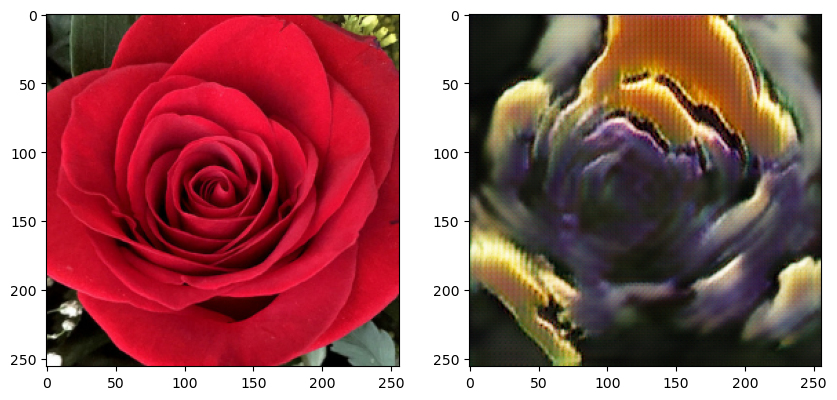

In [284]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(img)
ax[1].imshow(gen_img.astype(dtype=np.float32))